In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

To iterate easier over all Chunks, we create an auxiliary txt file with the names of all books on GutenQA.


In [2]:
path = "<./put_here_path_to_files/>Project-Gutenberg-Embeddings"
txtIn  = f'{path}/gutenberg_list.txt'

lines_list = []

try:
    with open(txtIn, 'r') as file:
        # Read each line, remove newline character, and store it in the list
        lines_list = [line.strip() for line in file.readlines()]
except FileNotFoundError:
    print("File not found. Please check the file path.")

# Print the list containing lines from the file without newline characters
print(lines_list)

['A_Christmas_Carol_-_Charles_Dickens', "A_Connecticut_Yankee_in_King_Arthur's_Court_-_Mark_Twain", 'A_Crystal_Age_-_W_H_Hudson', 'A_Legend_Of_Montrose_-_Sir_Walter_Scott', 'A_Portrait_of_the_Artist_as_a_Young_Man_-_James Joyce', 'A_Room_with_a_View_-_E._M._Forster', 'A_Study_in_Scarlet_-_Arthur_Conan_Doyle', 'A_Tale_of_Two_Cities_-_Charles_Dickens', 'Adventures_of_Huckleberry_Finn_-_Mark_Twain', "Alice's_Adventures_in_Wonderland_-_Lewis_Carroll", 'Anna_Karenina_-_Leo_Tolstoy', 'Anne_of_Green_Gables_-_L._M._Montgomery', 'Around_the_World_in_Eighty_Days_-_Jules_Verne', 'Beyond_Good_and_Evil_-_Friedrich_Wilhelm_Nietzsche', 'Carmilla_-_Joseph_Sheridan_Le_Fanu', 'Cranford_-_Elizabeth_Cleghorn_Gaskell', 'Crime_and_Punishment_-_Fyodor_Dostoyevsky', 'Daddy_takes_us_to_the_Garden_-_Howard_R._Garis', 'David_Copperfield_-_Charles_Dickens', 'Dracula_-_Bram_Stoker', 'Dubliners_-_James_Joyce', 'Emma_-_Jane_Austen', 'Frankenstein_Or_The_Modern_Prometheus_-_Mary_Wollstonecraft_Shelley', 'Great_Expect

In [3]:
def get_top_k(top_k, query_individual_embedding_numpy, chunks_type):

    similarity = []

    
    if chunks_type == "Custom":
        similarity = np.dot(book_embeddings_numpy_chunks_auto_generated, np.transpose(query_individual_embedding_numpy))

    if chunks_type == "Semantic":
        similarity = np.dot(book_embeddings_numpy_chunks_semantic, np.transpose(query_individual_embedding_numpy))

    if chunks_type == "Paragraph":
        similarity = np.dot(book_embeddings_numpy_chunks_paragraph, np.transpose(query_individual_embedding_numpy))

    if chunks_type == "Langchain":
        similarity = np.dot(book_embeddings_chunks_numpy_langchain, np.transpose(query_individual_embedding_numpy))

    if chunks_type == "Propositions":
        similarity = np.dot(book_embeddings_chunks_numpy_propositions, np.transpose(query_individual_embedding_numpy))

    if chunks_type == "HyDE":
        similarity = np.dot(book_embeddings_chunks_numpy_langchain, np.transpose(query_individual_embedding_numpy))

    

    top_indices = np.argsort(similarity, axis=0)[-top_k:]
    top_indices = top_indices[::-1]

    respostas = []

    for i in range(len(top_indices)):

        if chunks_type == "Custom":
            respostas.append(book_chunks_auto_generated.at[top_indices[i], 'Chunk'])

        if chunks_type == "Semantic":
            respostas.append(book_chunks_semantic.at[top_indices[i], 'Chunk'])

        if chunks_type == "Paragraph":
            respostas.append(book_chunks_paragraph.at[top_indices[i], 'Chunk'])
        
        if chunks_type == "Langchain":
            respostas.append(book_chunks_langchain.at[top_indices[i], 'Chunk'])

        if chunks_type == "Propositions":
            respostas.append(book_chunks_propositions.at[top_indices[i], 'Propositions'])

        if chunks_type == "HyDE":
            respostas.append(book_chunks_langchain.at[top_indices[i], 'Chunk'])
        



    return respostas

In [4]:
# Gold label is the substring that is present on the Chunk_Must_Contain column.
# We look if that substring is present on the retrieved chunks. 
# If it is, that index position on 'relevance' list receives the value = 1 and the remaining positions 0.
def find_index_of_match(respostas, gold_label):
    relevance = []
    gold_label = gold_label.lower()
    for _, item in enumerate(respostas):
        if gold_label in item.lower():
            relevance.append(1)
            relevance = relevance + ((len(respostas) - len(relevance))* ([0]))
            break
        else:
            relevance.append(0)
    return relevance


#In theory there is only 1 document that correctly answers the query, hence the simplistic implementation of Recall.
def compute_Recall(rel):
    if 1 in rel:
        return 1 
    else:
        return 0
    

def compute_DCG(rel):
    aux = 0
    for i in range(1, len(rel)+1):
        aux = aux + (np.power(2,rel[i-1])-1) / (np.log2(i+1))
    return(aux)

In [5]:
# List to hold all the DataFrames created in each iteration
all_dfs = []

for lines in lines_list:
    book_name = lines

    book_chunks_paragraph = pd.read_excel(f"<./put_here_path_to_files/>Project-Gutenberg-Embeddings/{book_name}/{book_name}_Paragraph.xlsx")
    book_chunks_paragraph['Chunk'] = book_chunks_paragraph['Chunk'].str.lower()

    book_chunks_auto_generated = pd.read_excel(f"<./put_here_path_to_files/>Project-Gutenberg-Embeddings/{book_name}/Gemini_Chunks_-_{book_name}.xlsx")
    book_chunks_auto_generated['Chunk'] = book_chunks_auto_generated['Chunk'].str.lower()

    book_chunks_semantic = pd.read_excel(f"<./put_here_path_to_files/>Project-Gutenberg-Embeddings/{book_name}/{book_name}_Semantic.xlsx")
    book_chunks_semantic['Chunk'] = book_chunks_semantic['Chunk'].str.lower()

    book_chunks_langchain = pd.read_excel(f"<./put_here_path_to_files/>Project-Gutenberg-Embeddings/{book_name}/{book_name}_Langchain.xlsx")
    book_chunks_langchain['Chunk'] = book_chunks_langchain['Chunk'].str.lower()

    book_chunks_propositions = pd.read_excel(f"<./put_here_path_to_files/>Project-Gutenberg-Embeddings/{book_name}/{book_name}_Propositions.xlsx")
    book_chunks_propositions['Propositions'] = book_chunks_propositions['Propositions'].str.lower()

    book_embeddings_chunks_paragraph = pd.read_csv(f"<./put_here_path_to_files/>Project-Gutenberg-Embeddings/{book_name}/Embeddings_{book_name}_Paragraph.csv")
    book_embeddings_numpy_chunks_paragraph = book_embeddings_chunks_paragraph.to_numpy()

    book_embeddings_chunks_auto_generated = pd.read_csv(f"<./put_here_path_to_files/>Project-Gutenberg-Embeddings/{book_name}/Embeddings_{book_name}_Gemini.csv")
    book_embeddings_numpy_chunks_auto_generated = book_embeddings_chunks_auto_generated.to_numpy()

    book_embeddings_chunks_semantic = pd.read_csv(f"<./put_here_path_to_files/>Project-Gutenberg-Embeddings/{book_name}/Embeddings_{book_name}_Semantic.csv")
    book_embeddings_numpy_chunks_semantic = book_embeddings_chunks_semantic.to_numpy()

    book_embeddings_chunks_langchain = pd.read_csv(f"<./put_here_path_to_files/>Project-Gutenberg-Embeddings/{book_name}/Embeddings_{book_name}_Langchain.csv")
    book_embeddings_chunks_numpy_langchain = book_embeddings_chunks_langchain.to_numpy()

    book_embeddings_chunks_propositions = pd.read_csv(f"<./put_here_path_to_files/>Project-Gutenberg-Embeddings/{book_name}/Embeddings_{book_name}_Propositions.csv")
    book_embeddings_chunks_numpy_propositions = book_embeddings_chunks_propositions.to_numpy()
    
    eval_retrieval_dataset = pd.read_excel(f"<./put_here_path_to_files/>Project-Gutenberg-Embeddings/{book_name}/Questions_-_{book_name}.xlsx")
    eval_retrieval_dataset_embeddings = pd.read_csv(f"<./put_here_path_to_files/>Project-Gutenberg-Embeddings/{book_name}/Embeddings_Questions_{book_name}.csv")
    eval_retrieval_numpy_dataset_embeddings = eval_retrieval_dataset_embeddings.to_numpy()

    eval_retrieval_dataset_hyde = pd.read_excel(f"<./put_here_path_to_files/>Project-Gutenberg-Embeddings/{book_name}/Questions_-_{book_name}.xlsx")
    eval_retrieval_dataset_hyde_embeddings = pd.read_csv(f"<./put_here_path_to_files/>Project-Gutenberg-Embeddings/{book_name}/Embeddings_Questions_Hyde_{book_name}.csv")
    eval_retrieval_numpy_dataset_hyde_embeddings = eval_retrieval_dataset_hyde_embeddings.to_numpy()


    types = ["Custom", "Semantic", "Paragraph", "Langchain", "Propositions", "HyDE"]
    DCG_custom = []
    DCG_semantic = []
    DCG_paragraph = []
    DCG_langchain = []
    DCG_propositions = []
    DCG_HyDE = []

    for i in tqdm(range(len(types))):#Iterar nos 4 tipos
        for j in [1, 2, 5, 10, 20]:#Calcular o DCG@k -> k varia entre 1-20
            DCG_aux = 0
            DCG_custom_aux = []
            DCG_semantic_aux = []
            DCG_paragraph_aux = []
            DCG_langchain_aux = []
            DCG_propositions_aux = []
            DCG_HyDE_aux = []
            respostas = []

            for k in range(len(eval_retrieval_dataset)):
                if types[i] == "HyDE":
                    respostas = get_top_k( top_k = j, query_individual_embedding_numpy= eval_retrieval_numpy_dataset_hyde_embeddings[k] , chunks_type = types[i])
                else:
                    respostas = get_top_k( top_k = j, query_individual_embedding_numpy= eval_retrieval_numpy_dataset_embeddings[k] , chunks_type = types[i])
                
                
                gold_label = eval_retrieval_dataset.loc[k, "Chunk Must Contain"]
                rel = find_index_of_match(respostas=respostas, gold_label=gold_label)
                DCG_aux = compute_DCG(rel)
                
                if types[i] == "Custom":
                    DCG_custom_aux.append(DCG_aux)
                elif types[i] == "Semantic":
                    DCG_semantic_aux.append(DCG_aux)
                elif types[i] == "Paragraph":
                    DCG_paragraph_aux.append(DCG_aux)
                elif types[i] == "Langchain":
                    DCG_langchain_aux.append(DCG_aux)
                elif types[i] == "HyDE":
                    DCG_HyDE_aux.append(DCG_aux)
                elif types[i] == "Propositions":
                    gold_label = eval_retrieval_dataset.loc[k, "Proposition Answer"]
                    rel = find_index_of_match(respostas=respostas, gold_label=gold_label)
                    DCG_aux = compute_DCG(rel)
                    DCG_propositions_aux.append(DCG_aux)


                

            if types[i] == "Custom":
                DCG_custom.append(np.mean(DCG_custom_aux))
            elif types[i] == "Semantic": 
                DCG_semantic.append(np.mean(DCG_semantic_aux))
            elif types[i] == "Paragraph":
                DCG_paragraph.append(np.mean(DCG_paragraph_aux))
            elif types[i] == "Langchain":
                DCG_langchain.append(np.mean(DCG_langchain_aux))
            elif types[i] == "HyDE":
                DCG_HyDE.append(np.mean(DCG_HyDE_aux))
            elif types[i] == "Propositions":
                DCG_propositions.append(np.mean(DCG_propositions_aux))



        # Create DataFrame for the current book
    df = pd.DataFrame({
        'Top-k': [1, 2, 5, 10, 20],
        'LumberChunker': DCG_custom,
        'Recursive Chunking (Langchain)': DCG_langchain,
        'Semantic Chunking': DCG_semantic,
        'Paragraph': DCG_paragraph,
        'HyDE': DCG_HyDE,
        'Propositions': DCG_propositions,
    })

    # Append this DataFrame to the list
    all_dfs.append(df)

# Concatenate all DataFrames
final_df = pd.concat(all_dfs)
# Compute the mean of each row grouped by 'Top-k'
final_mean_df = final_df.groupby('Top-k').mean()

100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


<h1>Plot Results<h1>

In [6]:
final_df

,Top-k,LumberChunker,Recursive Chunking (Langchain),Semantic Chunking,Paragraph,HyDE,Propositions
0,1,0.533333,0.533333,0.333333,0.300000,0.333333,0.200000
1,2,0.596426,0.575395,0.438488,0.384124,0.438488,0.242062
2,5,0.627449,0.602646,0.451383,0.415147,0.488488,0.288290
3,10,0.662307,0.624273,0.496640,0.491700,0.543896,0.300164
4,20,0.679470,0.641904,0.504973,0.491700,0.553194,0.308011
...,...,...,...,...,...,...,...
0,1,0.433333,0.400000,0.266667,0.200000,0.333333,0.400000
1,2,0.475395,0.526186,0.329760,0.284124,0.354364,0.421031
2,5,0.537440,0.526186,0.377449,0.324270,0.387698,0.475533
3,10,0.568221,0.526186,0.422060,0.346178,0.398809,0.497160


In [7]:
final_mean_df

,LumberChunker,Recursive Chunking (Langchain),Semantic Chunking,Paragraph,HyDE,Propositions
Top-k,,,,,,
1,0.482816,0.390448,0.295057,0.365414,0.334770,0.369103
2,0.548672,0.453759,0.353110,0.421153,0.397464,0.424219
5,0.593739,0.506610,0.406735,0.458725,0.450695,0.448835
10,0.609950,0.532577,0.431455,0.477212,0.481491,0.456568
20,0.620977,0.547246,0.447417,0.490020,0.499287,0.461926


Plot DCG@k for the multiple methods

In [8]:
# Set a professional font
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 12,
        }

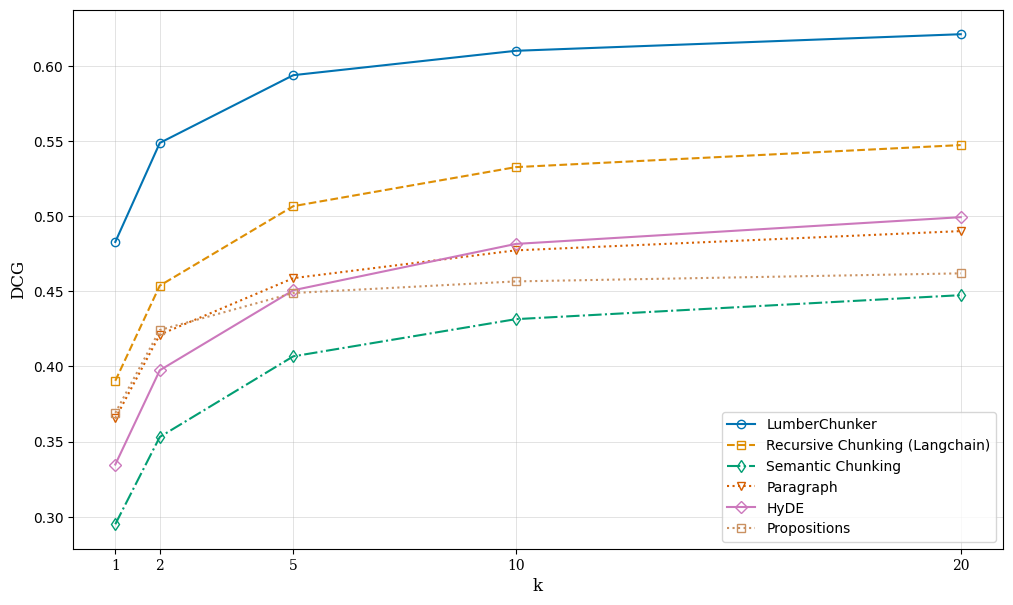

In [9]:
# Set a professional color palette (colorblind-friendly)
sns.set_palette("colorblind")

plt.figure(figsize=(12, 7))  # Adjust the figure size as needed


line_styles = ['-', '--', '-.', ':', '-', ':']  # Different line styles
markers = ['o', 's', 'd', 'v', 'D', 's']  # Different markers



for i, column in enumerate(['LumberChunker', 'Recursive Chunking (Langchain)',
       'Semantic Chunking', 'Paragraph', 'HyDE', 'Propositions']):
    x_values = [1, 2, 5, 10, 20]
    # x_values = [1, 2, 3, 4, 5]
    y_values = final_mean_df[column]
    plt.plot(x_values, y_values, linestyle=line_styles[i], marker=markers[i], label=column, markersize = 6, mfc='none')

plt.title('', fontdict=font)
plt.xlabel('k', fontdict=font)
plt.ylabel('DCG', fontdict=font)

# Set custom x-axis tick values every 2 points
x_ticks = x_values[::1]
plt.xticks(x_ticks, fontname='serif', fontsize=10)

plt.legend()
plt.grid(linewidth=0.5, linestyle='-', alpha=0.5)  # Adjust linewidth and alpha for grid lines
plt.show()